# Build a Molecular Search Engine in Minutes

This notebook illustrates how to build a molecular search engine from scratch [Milvus](https://milvus.io/) and [Towhee](https://towhee.io/). Milvus is the most advanced open-source vector database built for AI applications and supports nearest neighbor embedding search across tens of millions of entries, and Towhee is a framework that provides ETL for unstructured data using SoTA machine learning models.

We will go through molecular **similarity search** SMILES. Moreover, we managed to make the core functionality as simple as 10 lines of code with Towhee, so that you can start hacking your own molecular search engine.

## Preparations

### Install Dependencies

First we need to install dependencies such as towhee, rdkit and gradio.

In [1]:
! python -m pip install -q towhee towhee.models rdkit-pypi gradio

Please make sure that you have started a [Milvus service](https://milvus.io/docs/install_standalone-docker.md). This notebook uses [milvus 2.2.10](https://milvus.io/docs/v2.2.x/install_standalone-docker.md) and [pymilvus 2.2.11](https://milvus.io/docs/release_notes.md#2210).

In [2]:
! python -m pip install -q pymilvus==2.2.11

### Prepare the Data

There is a subset of the [Pubchem dataset](https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/) (10000 SMILES) used in this demo, everyone can download on [Github](https://github.com/towhee-io/examples/releases/download/data/pubchem_10000.smi).

In [3]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/pubchem_10000.smi -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  561k  100  561k    0     0   214k      0  0:00:02  0:00:02 --:--:--  391k


**pubchem_10000.smi**: a file containing SMILES and corresponding ids.

Let's take a quick look:

In [4]:
import pandas as pd

df = pd.read_csv('pubchem_10000.smi')
df.head()

,smiles,id
0,COc1cc(C=NNC(=O)CC2(C)OCCO2)cc(c1OCc1cccc2c1cc...,2860827
1,Fc1ccc(cc1)C=C1C(=O)NC(=S)N(C1=O)c1ccc(cc1Cl)Cl,2860828
2,O=C1NC(=C(C(N1)c1cccc(c1)Br)C(=O)Nc1ccc(cc1)Cl)C,2860829
3,COc1ccc(c(c1)OC)C=C1C(=O)NC(=S)N(C1=O)c1cccc(c...,2860830
4,Nc1ccn(n1)c1ccccc1.Cl,2860831


To use the dataset for molecular search, let's first define the dictionary and helper function:
- `to_images(input)`: convert the input smiles or results to towhee.Image for display.

In [5]:
from rdkit.Chem import Draw
from rdkit import Chem
from towhee.types.image_utils import from_pil

def to_images(data):
    imgs = []
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        img = from_pil(Draw.MolToImage(mol))
        imgs.append(img)
    return imgs

### Create Milvus Collection

Next to create the `molecular_search` collection in Milvus. It's worth to note that the vector field of this collection is the type of "BINARY_VECTOR".

In [6]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

MILVUS_HOST = '127.0.0.1'
MILVUS_PORT = '19530'
connections.connect(host=MILVUS_HOST, port=MILVUS_PORT)

def create_milvus_collection(collection_name, dim):    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='smiles', dtype=DataType.VARCHAR, descrition='SMILES', max_length=500),
    FieldSchema(name='embedding', dtype=DataType.BINARY_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='molecular similarity search')
    collection = Collection(name=collection_name, schema=schema)
    
    index_params = {"index_type": "BIN_FLAT", "params": {"nlist": 1024}, "metric_type": "JACCARD"}
    collection.create_index(field_name="embedding", index_params=index_params)
    
    return collection

collection = create_milvus_collection('molecular_search', 2048)

## Molecular Search Engine

In this section, we will show how to build our molecular search engine using Milvus. The basic idea behind Molecular Search is to use Towhee to generate molecular fingerprints from SMILES and compare the queried fingerprints with the fingerprints stored in Milvus.

We use Towhee, a machine learning framework that allows the creation of data processing pipelines. Towhee also provides predefined operators for implementing insert and query operations in Milvus.

### Load Molecular Fingerprint into Milvus

We first generate fingerprint from SMILES with daylight algorithm and insert the fingerprints into Milvus. Towhee provides a [method-chaining style API](https://towhee.readthedocs.io/en/main/index.html) so that users can assemble a data processing pipeline with operators.

In [8]:
from towhee import ops, pipe

insert_pipe = (pipe.input('df')
                   .flat_map('df', ('smiles', 'id'), lambda df: df.values.tolist())
                   .map('smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))
                   .map(('id', 'smiles', 'fp'), 'res', ops.ann_insert.milvus_client(host=MILVUS_HOST, 
                                                                           port=MILVUS_PORT,
                                                                           collection_name='molecular_search'))
                   .map('smiles', 'smiless', lambda x: print(x))
                   .output('res')
)

In [9]:
%%time
insert_pipe(df)

In [11]:
collection.flush()
print('Total number of inserted data is {}.'.format(collection.num_entities))

Total number of inserted data is 10000.


#### Explanation of Data Processing Pipeline

Here is detailed explanation for each line of the code:

`.flat_map('df', ('smiles', 'id'), lambda df: df.values.tolist())`: read tabular data from the df and flatten(smiles and id columns);

`.map('smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))`: use the daylight algorithm to generate fingerprint with the [rdkit operator](https://towhee.io/molecular-fingerprinting/rdkit) in towhee hub;

`.map(('id', 'fp'), 'res', ops.ann_insert.milvus_client(host='127.0.0.1', port='19530', collection_name='molecular_search'))`: insert molcular fingerprints in to Milvus;

Then we decompose the pipeline into stages to get a more intuitive understanding of what's going on

- read df data, get a list with two columns and flatten it:

In [12]:
from towhee import DataCollection

p1 = (pipe.input('df')
          .flat_map('df', ('smiles', 'id'), lambda df: df.values.tolist())
          .output('smiles', 'id')
     )
res = p1(df.head(3))
DataCollection(res).show()

smiles,id
COc1cc(C=NNC(=O)CC2(C)OCCO2)cc(c1OCc1cccc2c1cccc2)Br,2860827
Fc1ccc(cc1)C=C1C(=O)NC(=S)N(C1=O)c1ccc(cc1Cl)Cl,2860828
O=C1NC(=C(C(N1)c1cccc(c1)Br)C(=O)Nc1ccc(cc1)Cl)C,2860829


- generate fingerprint with `fp` column

In [13]:
p1 = (pipe.input('df')
          .flat_map('df', ('smiles', 'id'), lambda df: df.values.tolist())
          .map('smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))
          .output('smiles', 'id', 'fp')
     )
res = p1(df.head(3))
DataCollection(res).show()

smiles,id,fp
COc1cc(C=NNC(=O)CC2(C)OCCO2)cc(c1OCc1cccc2c1cccc2)Br,2860827,b'\xa1\x00\x88#\x067\xb0\xa9S\xa2\x8c8\x8b\xc25\xe3\x01\x98b@G\x8dQ\x85\xa6(\xb1B \x16\xa0`\x00dFL\x00\x7f\x93\x02\x8e\x0b\xe4\...
Fc1ccc(cc1)C=C1C(=O)NC(=S)N(C1=O)c1ccc(cc1Cl)Cl,2860828,"b""\xe64\xf0\t\xd2\xfbT\x9eEt(,\xbd\x19\xd3\x82b\xe3\xe8%B\xedx\xd0\xed\xfa\x8f\xf6\x95hM\xb4\xc1\x14Q\\\\\xe3\x10\x0f\x89DW\x94\..."
O=C1NC(=C(C(N1)c1cccc(c1)Br)C(=O)Nc1ccc(cc1)Cl)C,2860829,b'6O\x1ci@\xdan\x85\xd5\xdb\x88\x19\xcd:\xd9\x1ek\x98\xe1\xe4_\xafxc6\xf2r\xfb\x86\x8c\xc3\xfeg\xd0\xbb\x08\xdeW\xf0\xdf\x15D\x0...


### Query Molecular from Milvus with Towhee

Now that fingerprint for candidate SMILES have been inserted into Milvus, we can query across it. Again, we use Towhee to load the input SMILES, compute a fingerprint, and use it as a query in Milvus. 

#### similarity search

In [14]:
search_pipe = (pipe.input('query_smiles')
                   .map('query_smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))
                   .flat_map('fp', ('id', 'score', 'similar_smiles'), ops.ann_search.milvus_client(host=MILVUS_HOST, 
                                                                  port=MILVUS_PORT,
                                                                  collection_name='molecular_search',
                                                                  param={"metric_type": "JACCARD", "nprobe": 10},
                                                                  output_fields=['smiles']))
                   .output('query_smiles', 'similar_smiles')
)

In [15]:
res = search_pipe('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')
DataCollection(res).show()

query_smiles,similar_smiles
CN1C=NC2=C1C(=O)N(C(=O)N2C)C,Cn1cnc2c1c(=O)n(C)c(=O)n2C
CN1C=NC2=C1C(=O)N(C(=O)N2C)C,Cn1c2nc[nH]c2c(=O)n(C)c1=O
CN1C=NC2=C1C(=O)N(C(=O)N2C)C,Cn1cnc2c1c(=O)[nH]c(=O)n2C
CN1C=NC2=C1C(=O)N(C(=O)N2C)C,Cn1cnc2[nH]c(=O)n(C)c(=O)c21
CN1C=NC2=C1C(=O)N(C(=O)N2C)C,Cn1c2nc[nH]c2c(=O)[nH]c1=O


If you want to show the molecular structure with images, you can use the `to_images` function.

In [16]:
search_pipe1 = (pipe.input('query_smiles')
                   .map('query_smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))
                   .flat_map('fp', ('id', 'score', 'similar_smiles'), ops.ann_search.milvus_client(host=MILVUS_HOST, 
                                                                  port=MILVUS_PORT,
                                                                  collection_name='molecular_search',
                                                                  limit=6,
                                                                  param={"metric_type": "JACCARD", "nprobe": 10},
                                                                  output_fields=['smiles']))
                   .window_all('query_smiles', 'query_smiles', lambda x: to_images(x[:1]))
                   .window_all('similar_smiles', 'similar_smiles', to_images)
                   .output('query_smiles', 'similar_smiles')
)

query_smiles,similar_smiles
,

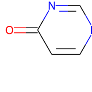
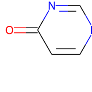
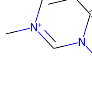
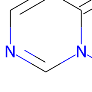
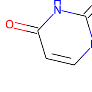
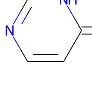
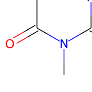

In [17]:
res = search_pipe1('Cn1ccc(=O)nc1')
DataCollection(res).show()